<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício

A atividade é **prever para as próximas 6h o valor da concentração de PM2.5**.
Utilize os conceitos aprendidos até aqui, **testando diferentes modelos de IA** e **diferentes abordagens para conseguir prever com o melhor desempenho o valor das próximas 6h da concentração de PM2.5 para uma série histórica de sua escolha.**  
1.   Escolha uma estação de monitoramento de uma das cidades com que irá trabalhar; 
2.   Faça uma análise exploratória dos dados, avaliando estatisticamente e graficamente como os dados se comportam;
3.   Explore as técnicas **MLP, RNN simples, LSTM, GRU, CNN1D, FCN+LSTM e Conv2DLSTM**, utilizando a camada **TimeDistributed**;
4.   Escolha, com base na avaliação do **loss** e das métricas **MAE, MSE, NMSE, r, R2 e Fac2** qual foi o melhor modelo (e apresente justificando a resposta);
5.   Use o ano de 2015 somente para fins de teste.

### Observação: 
*   *Apresente os resultados de forma lógica, organizada e que seja reprodutível pelo professor (linhas comentadas);*
*   *Apresentação de métricas, gráficos, são essenciais para entendimento dos modelos e justificativas.*

### Opcionais:

*   Pode-se utilizar as informações meteorológicas para melhorar a qualidade do modelo final;
*   Interessante, mas não obrigatório, a utilização de wavelets para feature augmentation.


### Links:

* [Código para o colab (referência)](https://colab.research.google.com/drive/1b5177FoO4JsyOKN8dmbmTjvPi32b95of?usp=sharing) 

* [Link da base de dados da atividade](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)

* [Link para download da base de dados da atividade](https://drive.google.com/file/d/19FsUZXhakjteNoC3nsqUe2aTq3s7GoQI/view?usp=drive_web&authuser=1)


In [23]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from collections import Counter

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, MaxPooling3D, Flatten, SimpleRNN, ConvLSTM2D, RepeatVector, TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Para garantir que nossos resultados sejam reprodutíveis, vamos fixar a semente de aleatorização (random seed)

In [4]:
# fixa random seed para garantir reprodutibilidade
np.random.seed(0)

In [5]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [12]:
# carrega o dataset
#df = pd.read_csv('/content/drive/MyDrive/Disciplinas/2021.2/Tópicos_Intel_Comp/Séries_Temporais/FiveCitiesPM/Shanghai.csv', usecols=[1], engine='python', skipfooter=3)
df = pd.read_csv('/content/drive/MyDrive/Disciplinas/2021.2/Tópicos_Intel_Comp/Séries_Temporais/FiveCitiesPM/Shanghai.csv', engine='python', skipfooter=3)
data = df.values
#data = data.astype('float32')
print('Quantidade de dados no arquivo:',len(data))

Quantidade de dados no arquivo: 52581


In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52581 entries, 0 to 52580
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             52581 non-null  int64  
 1   year           52581 non-null  int64  
 2   month          52581 non-null  int64  
 3   day            52581 non-null  int64  
 4   hour           52581 non-null  int64  
 5   season         52581 non-null  int64  
 6   PM_Jingan      24698 non-null  float64
 7   PM_US Post     34036 non-null  float64
 8   PM_Xuhui       25187 non-null  float64
 9   DEWP           52568 non-null  float64
 10  HUMI           52568 non-null  float64
 11  PRES           52553 non-null  float64
 12  TEMP           52568 non-null  float64
 13  cbwd           52569 non-null  object 
 14  Iws            52569 non-null  float64
 15  precipitation  48572 non-null  float64
 16  Iprec          48572 non-null  float64
dtypes: float64(10), int64(6), object(1)
memory usage: 

In [14]:
df.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,0.0,0.0


In [15]:
print (df.loc[df["PM_US Post"].first_valid_index()])

No                17443
year               2011
month                12
day                  28
hour                 18
season                4
PM_Jingan           NaN
PM_US Post           36
PM_Xuhui            NaN
DEWP                  4
HUMI                 62
PRES             1027.1
TEMP                 11
cbwd                 NE
Iws                   8
precipitation         0
Iprec                 0
Name: 17442, dtype: object


In [16]:
df = df.iloc[24:, :]

In [17]:
df.interpolate(inplace=True)

In [18]:
# Index dataframe using datetime
df.index = pd.to_datetime(df.year*1000000 + df.month*10000 + df.day*100 + df.hour, format='%Y%m%d%H')

In [19]:
df.drop(["No", "day", "hour", "PM_Jingan", "PM_Xuhui"], axis=1, inplace=True)

In [20]:
# Rename columns to be easily recognizable
df = df.rename(columns={'PM_US Post': 'pm25',
                        'DEWP': 'dew_point',
                        'HUMI': 'humidity',
                        'PRES': 'pressure',
                        'TEMP' : 'temp',
                        'cbwd': 'wind_dir',
                        'Iws': 'wind_speed',
                        'Iprec': 'cum_precipitation'})

In [21]:
def wind_dir_mode(x):
    c = Counter(x)
    return(c.most_common()[0][0])

In [24]:
df = df.resample('D').wind_dir.agg(wind_dir=wind_dir_mode).join(df.drop("cum_precipitation", axis=1).resample('D').mean()).join(df.cum_precipitation.resample("D").max())


In [25]:
df.head()

,wind_dir,year,month,season,pm25,dew_point,humidity,pressure,temp,wind_speed,precipitation,cum_precipitation
2010-01-02,NW,2010,1,4,NaN,2.739130,68.415217,1018.978261,8.478261,11.130435,0.0,0.0
2010-01-03,SE,2010,1,4,NaN,3.125000,72.355000,1020.062500,8.000000,40.791667,0.0,0.0
2010-01-04,NW,2010,1,4,NaN,0.583333,73.022500,1019.645833,5.250000,18.041667,0.0,0.0
2010-01-05,NE,2010,1,4,NaN,-6.958333,61.919167,1028.683333,-0.500000,28.458333,0.0,0.0
2010-01-06,NE,2010,1,4,NaN,-5.500000,62.430417,1029.408333,1.208333,16.125000,0.0,0.0


#Tratando os dados

## Visualizando os dados

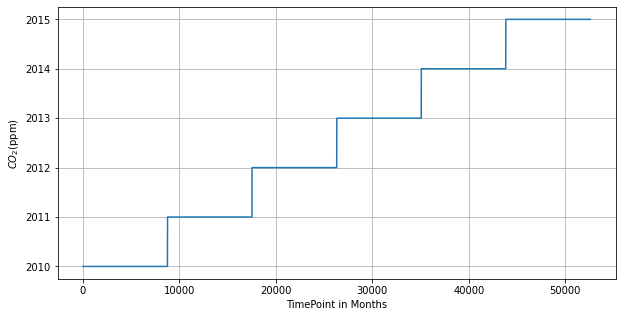

In [14]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(data);


Em séries temporais, a sequência dos dados é importante. Para criar a divisão entre treinamento e teste, utilizaremos a primeira parte da série para treinamento, e a última para o teste.

In [16]:
# split into train and test sets
train_size = int(len(data) * 0.7)
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('Dataset de treinamento contém: ', len(train),' dados')
print('Dataset de teste contém: ', len(test),' dados')

Dataset de treinamento contém:  36806  dados
Dataset de teste contém:  15775  dados


Os LSTMs são sensíveis à escala dos dados de entrada, especificamente quando as funções de ativação sigmóide ou tanh são usadas. É fundamental normalizar os dados para o intervalo de [0, 1]. Isso pode ser feito usando a classe de pré-processamento MinMaxScaler da biblioteca scikit-learn.